# 서울시 착한가격업소 현황
데이터 링크 : http://data.seoul.go.kr/dataList/OA-1173/S/1/datasetView.do

In [ ]:
!!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/일일 데이터 분석/

In [614]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
plt.rc('font',family='NanumBarunGothic')
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

raw_light_palette = [
    (0, 122, 255), # Blue
    (255, 149, 0), # Orange
    (52, 199, 89), # Green
    (255, 59, 48), # Red
    (175, 82, 222),# Purple
    (255, 45, 85), # Pink
    (88, 86, 214), # Indigo
    (90, 200, 250),# Teal
    (255, 204, 0)  # Yellow
]

light_palette = np.array(raw_light_palette)/255
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

def pie_plot(frequency,labels,palette,title=None):
  labels_frequency = zip(labels,frequency,palette) 
  labels_frequency = sorted(labels_frequency,key=lambda x: x[1],reverse=True)

  sorted_labels = [x[0] for x in labels_frequency] ## 정렬된 라벨
  sorted_frequency = [x[1] for x in labels_frequency] ## 정렬된 빈도수
  sorted_colors = [x[2] for x in labels_frequency] ## 정렬된 색상
  
  # 0값이 있는 경우 제거
  while 0 in sorted_frequency:
    idx = sorted_frequency.index(0)
    sorted_frequency.pop(idx)
    sorted_labels.pop(idx)
  
  fig = plt.figure(figsize=(10,10)) ## 캔버스 생성
  ax = fig.add_subplot() ## 프레임 생성
    
  ## 파이차트 출력
  pie = ax.pie(sorted_frequency,
               startangle=90, 
               counterclock=False, 
               colors = sorted_colors, 
               wedgeprops=wedgeprops
              )
  
  total = np.sum(frequency) ## 빈도수 합
  
  threshold = 5
  sum_pct = 0 ## 퍼센티지
  count_less_5pct = 0 ## 5%보다 작은 라벨의 개수
  spacing = 0.1 # 텍스트 사이의 간격

  for i,l in enumerate(sorted_labels):
      ang1, ang2 = ax.patches[i].theta1, ax.patches[i].theta2 ## 파이의 시작 각도와 끝 각도
      center, r = ax.patches[i].center, ax.patches[i].r ## 파이의 중심 좌표, 반지름
      
      ## 비율 상한선보다 작은 것들은 계단형태로 만든다.
      if sorted_frequency[i]/total*100 < threshold:
          x = (r/2+spacing*count_less_5pct)*np.cos(np.pi/180*((ang1+ang2)/2)) + center[0] ## 텍스트 x좌표
          y = (r/2+spacing*count_less_5pct)*np.sin(np.pi/180*((ang1+ang2)/2)) + center[1] ## 텍스트 y좌표
          count_less_5pct += 1
      else:
          x = (r/2)*np.cos(np.pi/180*((ang1+ang2)/2)) + center[0] ## 텍스트 x좌표
          y = (r/2)*np.sin(np.pi/180*((ang1+ang2)/2)) + center[1] ## 텍스트 y좌표
      
      ## 퍼센티지 출력
      if i < len(labels) - 1:
          sum_pct += float(f'{sorted_frequency[i]/total*100:.2f}')
          ax.text(x,y,f'{sorted_frequency[i]/total*100:.2f}%',ha='center',va='center',fontsize=15)
      else: ## 마지막 파이 조각은 퍼센티지의 합이 100이 되도록 비율을 조절
          ax.text(x,y,f'{100-sum_pct:.2f}%',ha='center',va='center',fontsize=15)
  
  plt.legend(pie[0],sorted_labels,fontsize=13) ## 범례
  if title:
    plt.title(title,size=20)
  plt.show()

In [615]:
df = pd.read_csv('./서울시 착한가격업소 현황.csv',encoding='cp949')

In [616]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118 entries, 0 to 1117
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   업소아이디    1118 non-null   int64 
 1   업소명      1118 non-null   object
 2   분류코드     1118 non-null   int64 
 3   분류코드명    1118 non-null   object
 4   업소 주소    1118 non-null   object
 5   업소 전화번호  1070 non-null   object
 6   찾아오시는 길  552 non-null    object
 7   업소정보     1103 non-null   object
 8   자랑거리     845 non-null    object
 9   추천수      1118 non-null   int64 
 10  기준년월     1118 non-null   object
 11  업소 사진    1118 non-null   object
dtypes: int64(3), object(9)
memory usage: 104.9+ KB


In [617]:
df.isnull().sum()

업소아이디        0
업소명          0
분류코드         0
분류코드명        0
업소 주소        0
업소 전화번호     48
찾아오시는 길    566
업소정보        15
자랑거리       273
추천수          0
기준년월         0
업소 사진        0
dtype: int64

In [618]:
# 업소 주소에서 동을 분리
# 서울특별시 중랑구 사가정로50길 67 (면목동)	-> 면목동

df['업소 동'] = df['업소 주소'].map(lambda x: " " if len(re.split('\(',x)) == 1 else re.split('\(',x)[1][:-1])
df['업소 주소'] = df['업소 주소'].map(lambda x: re.split('\(',x)[0])

gu = []
split_address = df['업소 주소'].map(lambda x : re.split(' ',x))

for i in range(len(split_address)):
  count = 0
  for word in split_address[i]:
    if ('구' in word) & ('구로동' not in word) & ('구의' not in word) & ('구로중앙로' not in word) & ('압구정' not in word) & ('한글' not in word) & ('구천면로' not in word) & ('구일로' not in word) & ('청구로' not in word):
      gu.append(word)
      count += 1
  if count == 0:
    gu.append('')

df['구'] = gu

In [619]:
df.head()

,업소아이디,업소명,분류코드,분류코드명,업소 주소,업소 전화번호,찾아오시는 길,업소정보,자랑거리,추천수,기준년월,업소 사진,업소 동,구
0,6017,아폴로헤어크리닉,5,이 미용업,서울특별시 중랑구 사가정로50길 67,495-7337,면목골목시장 65호,영업시간 :09:00~21:00 좌석수 :5 휴무일 :매주 수요일 예약 :불가능 카...,면목시장내 위치 형편이 어려우신 분은 요금을 할인해주며 20년간 봉사활동을 하시는 ...,450,22-6,http://tearstop.seoul.go.kr/mulga/photo/201511...,면목동,중랑구
1,6015,상록수미용실,5,이 미용업,서울특별시 중랑구 동일로99길 22,NaN,면목2동 다울아파트에서 동일로로 가는 골목에 위치,영업시간 : 09:30~21:00 좌석수 : 3 휴무일 : 매주 일요일 예약 :불가...,주 고객이 어르신들이라 가격을 저렴하게 책정하여 파마 14000원 등 파격적인 요금...,432,22-6,http://tearstop.seoul.go.kr/mulga/photo/201511...,면목동,중랑구
2,4506,열린미용실,5,이 미용업,서울특별시 관악구 난곡로40길 16,NaN,미성동 노선버스 신일교회앞 하차,영업시간 : 오전 9시 ~ 오후 8시 휴무일 : 매주 일요일 예약 : 가능 카드 :...,▷관악구 평균가격보다 20%이상 저렴. ▷경로자 장애인 할인해 드림 ▷한달에 한번씩...,336,22-6,http://tearstop.seoul.go.kr/mulga/photo/202207...,신림동,관악구
3,3002,미림17분칼라,13,기타서비스업종,서울특별시 관악구 호암로26길 1,871-7070,미림여고 입구 국민은행 옆 위치,영업시간 :오전 9시 30분 ~ 오후 9시 30분 휴무일 : 매월 둘째 넷째주 일...,▷관악구 평균가격(인화료 -3*5cm) 보다 20% 저렴,318,22-6,http://tearstop.seoul.go.kr/mulga/photo/202207...,신림동,관악구
4,4242,덕성이발관,5,이 미용업,서울특별시 관악구 장군봉2길 11,882-5875,봉천역 3번 출구에서 시장골목으로 100미터,영업시간 : 오전 7시 ~ 오후 9시 좌석수 : 4 휴무일 : 매주 화요일 주차 :...,▷관악구 평균가격보다 10%이상 저렴 ▷시설이 세련되지는 않았지만 동네 사랑방 같은...,264,22-6,http://tearstop.seoul.go.kr/mulga/photo/201204...,봉천동,관악구


In [ ]:
from geopy.geocoders import Nominatim
geo_local = Nominatim(user_agent='South Korea')

# 주소기반 위도, 경도 반환
def geocoding(address):
    try:
        geo = geo_local.geocode(address)
        x_y = [geo.latitude, geo.longitude]
        return x_y

    except:
        return [0,0]

latitude = []
longitude =[]

for i in df['업소 주소']:
    latitude.append(geocoding(i)[0])
    longitude.append(geocoding(i)[1])

df['경도'] = longitude
df['위도'] = latitude

In [630]:
# 공백제거
def normalize(input_string):
  if pd.isnull(input_string):
    return input_string

  while input_string.count(" ") > 0:
    input_string = input_string.replace(" ","")
  
  normalized_string = input_string.lower()

  return normalized_string

# 영업시간 추출
def opening_hours(input_string):
  if pd.isnull(input_string):
    return input_string
  
  if re.findall(r'영업시간.*?24시간',input_string):
    return '24시간'

  elif len(re.findall(r'영업시간:(\d+)[:~]*(\d+)[:~]*(\d+)[:~]*(\d+)',input_string)) > 0:
    h1,m1,h2,m2 = re.findall(r'영업시간:(\d+)[:~]*(\d+)[:~]*(\d+)[:~]*(\d+)',input_string)[0]
    h1,m1,h2,m2 = h1.zfill(2)[:2], m1.zfill(2)[:2], h2.zfill(2)[:2], m2.zfill(2)[:2]
    return f'{h1}:{m1}~{h2}:{m2}'
  
  elif len(re.findall(r'영업시간.*?[오전]?[ ]*([0-9]*)시.*?([0-9]*)[분]?.*?[오후]?[ ]*([0-9]*)시[ ]*([0-9]*)[분]?',input_string)):
    h1,m1,h2,m2 = re.findall(r'영업시간.*?[오전]?[ ]*([0-9]*)시.*?([0-9]*)[분]?.*?[오후]?[ ]*([0-9]*)시[ ]*([0-9]*)[분]?',input_string)[0]
    h1,m1,h2,m2 = h1.zfill(2)[:2], m1.zfill(2)[:2], h2.zfill(2)[:2], m2.zfill(2)[:2]
    return f'{h1}:{m1}~{h2}:{m2}'
  
  else:
    return 'None'

# 예약,배달,주차,카드 여부 추출
def check_col(info_string,word):
  if pd.isnull(info_string):
    return np.nan
  elif word in info_string:
    return '불가능' if '불가' in info_string.split(word)[1][:5] else '가능'
  else:
    return np.nan

# 좌석수 추출
def check_seat(info_string,word):
  if pd.isnull(info_string):
    return np.nan
  elif word in info_string:
    if re.search(r'[0-9]+',info_string.split(word)[1][:7]) is not None:
      return re.search(r'[0-9]+',info_string.split(word)[1][:7]).group()
    else:
      return np.nan
  else:
    return np.nan

def preprocessing(dataframe):
  df = dataframe.copy()

  df['업소정보'] = df['업소정보'].map(lambda x: normalize(x))
  df['영업시간'] = df['업소정보'].map(lambda x: opening_hours(x))
  df['예약'] = df['업소정보'].map(lambda x: check_col(x,'예약'))
  df['배달'] = df['업소정보'].map(lambda x: check_col(x,'배달'))
  df['주차'] = df['업소정보'].map(lambda x: check_col(x,'주차'))
  df['카드'] = df['업소정보'].map(lambda x: check_col(x,'카드'))
  df['좌석수'] = df['업소정보'].map(lambda x: check_seat(x,'좌석'))

  df['영업시작시간'] = df['영업시간'].map(lambda x: np.nan if (pd.isnull(x)) | (x == 'None') else '24시간' if x == '24시간' else x.split('~')[0])
  df['영업종료시간'] = df['영업시간'].map(lambda x: np.nan if (pd.isnull(x)) | (x == 'None') else '24시간' if x == '24시간' else x.split('~')[1])
  

  return df

In [631]:
data = preprocessing(df)

In [ ]:
data.to_csv('./착한가격업소 현황.csv',index=False)

In [622]:
data.head()

,업소아이디,업소명,분류코드,분류코드명,업소 주소,업소 전화번호,찾아오시는 길,업소정보,자랑거리,추천수,...,업소 동,구,영업시간,예약,배달,주차,카드,좌석수,영업시작시간,영업종료시간
0,6017,아폴로헤어크리닉,5,이 미용업,서울특별시 중랑구 사가정로50길 67,495-7337,면목골목시장 65호,영업시간:09:00~21:00좌석수:5휴무일:매주수요일예약:불가능카드:불가능주차:가...,면목시장내 위치 형편이 어려우신 분은 요금을 할인해주며 20년간 봉사활동을 하시는 ...,450,...,면목동,중랑구,09:00~21:00,불가능,NaN,가능,불가능,5,09:00,21:00
1,6015,상록수미용실,5,이 미용업,서울특별시 중랑구 동일로99길 22,NaN,면목2동 다울아파트에서 동일로로 가는 골목에 위치,영업시간:09:30~21:00좌석수:3휴무일:매주일요일예약:불가능카드:불가능주차:가...,주 고객이 어르신들이라 가격을 저렴하게 책정하여 파마 14000원 등 파격적인 요금...,432,...,면목동,중랑구,09:30~21:00,불가능,NaN,가능,불가능,3,09:30,21:00
2,4506,열린미용실,5,이 미용업,서울특별시 관악구 난곡로40길 16,NaN,미성동 노선버스 신일교회앞 하차,영업시간:오전9시~오후8시휴무일:매주일요일예약:가능카드:가능좌석수:3개기타:파마는기...,▷관악구 평균가격보다 20%이상 저렴. ▷경로자 장애인 할인해 드림 ▷한달에 한번씩...,336,...,신림동,관악구,09:00~08:00,가능,NaN,불가능,가능,3,09:00,08:00
3,3002,미림17분칼라,13,기타서비스업종,서울특별시 관악구 호암로26길 1,871-7070,미림여고 입구 국민은행 옆 위치,영업시간:오전9시30분~오후9시30분휴무일:매월둘째넷째주일요일주차:불가능카드결제:가능,▷관악구 평균가격(인화료 -3*5cm) 보다 20% 저렴,318,...,신림동,관악구,09:30~09:30,NaN,NaN,불가능,가능,NaN,09:30,09:30
4,4242,덕성이발관,5,이 미용업,서울특별시 관악구 장군봉2길 11,882-5875,봉천역 3번 출구에서 시장골목으로 100미터,영업시간:오전7시~오후9시좌석수:4휴무일:매주화요일주차:불가능예약:가능카드:불가능,▷관악구 평균가격보다 10%이상 저렴 ▷시설이 세련되지는 않았지만 동네 사랑방 같은...,264,...,봉천동,관악구,07:00~09:00,가능,NaN,불가능,불가능,4,07:00,09:00


In [623]:
# 22-6월의 데이터만 존재
data['기준년월'].unique()

array(['22-6'], dtype=object)

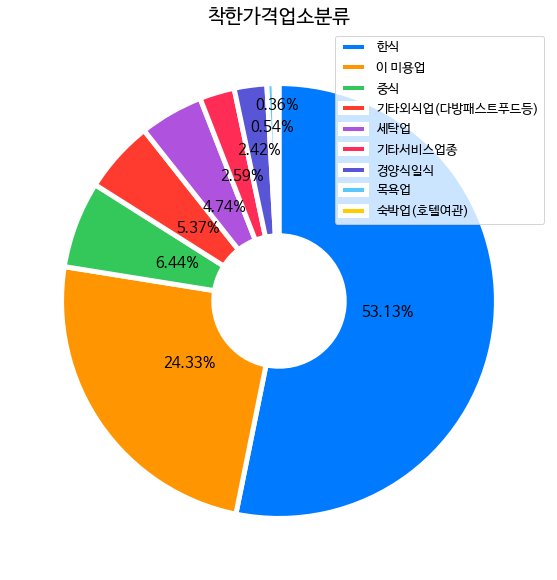

In [624]:
pie_plot(data['분류코드명'].value_counts(),data['분류코드명'].value_counts().index, light_palette,'착한가격업소분류')

- 착한가격업소 중 53%가 한식이었으며, 24%가 이 미용업이었다.

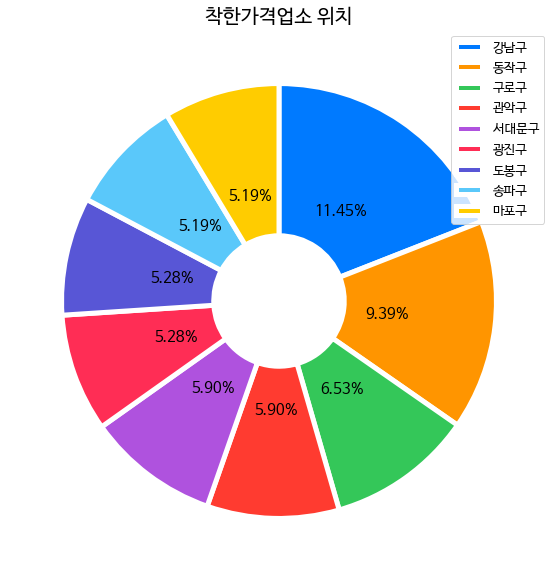

In [625]:
pie_plot(data['구'].value_counts(),data['구'].value_counts().index, light_palette,'착한가격업소 위치')

- 강남구가 전체의 11.45%로 가장 많았으며, 그 다음으로 동작구가 9.39%로 많았다.

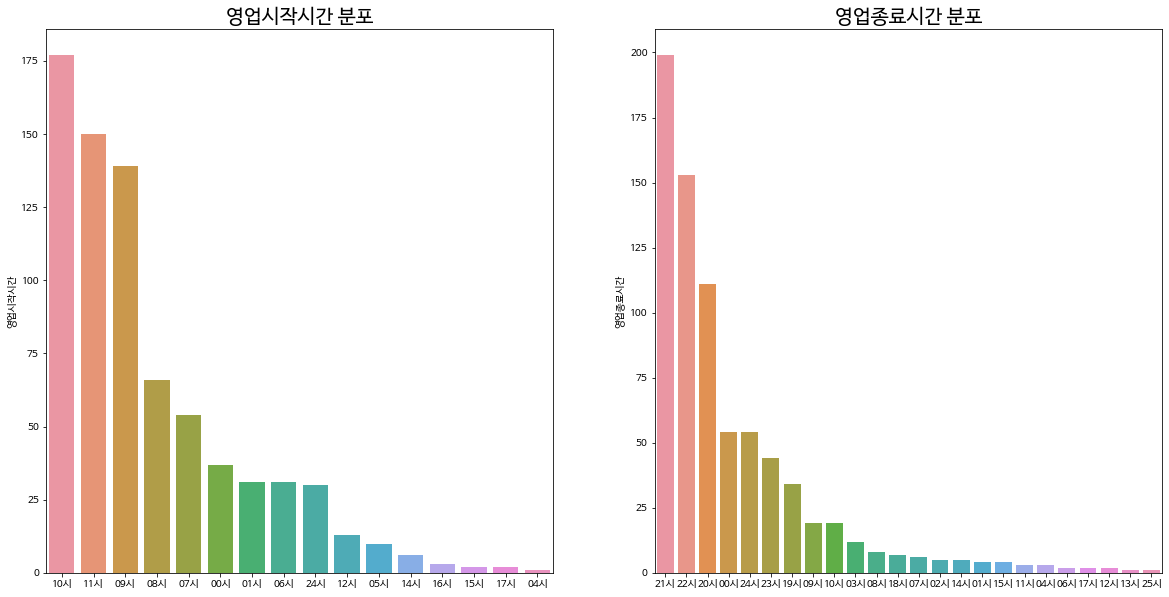

In [626]:
# 영업시간
starttime = data['영업시작시간'].map(lambda x: np.nan if pd.isnull(x) else x[:2]+'시')
endtime = data['영업종료시간'].map(lambda x: np.nan if pd.isnull(x) else x[:2]+'시')

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.barplot(x = starttime.value_counts().index , y= starttime.value_counts())
plt.title('영업시작시간 분포', size=20)

plt.subplot(1,2,2)
sns.barplot(x = endtime.value_counts().index , y= endtime.value_counts())
plt.title('영업종료시간 분포', size=20)

plt.show()

- 착한가격업소는 보통 9 ~ 11시 사이에 가게를 열고, 8 ~ 10시 사이에 가게를 닫는다.

<Figure size 2160x720 with 0 Axes>

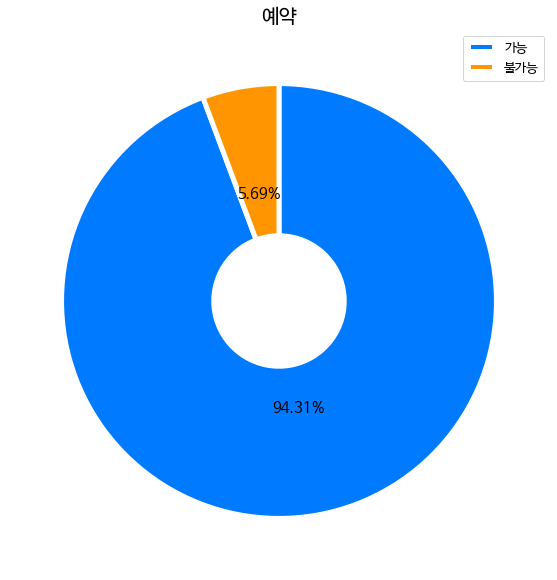

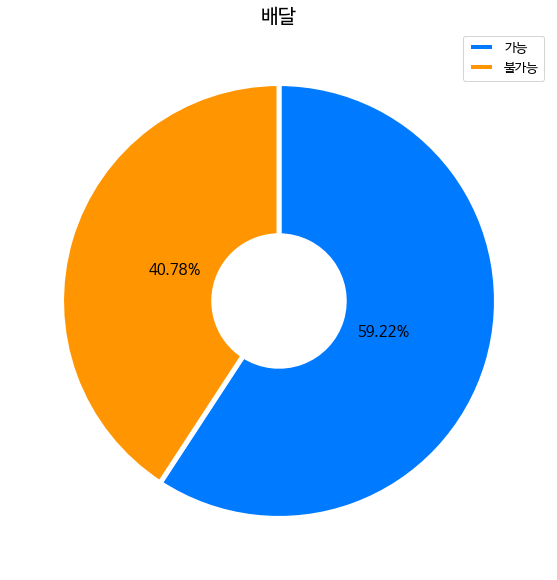

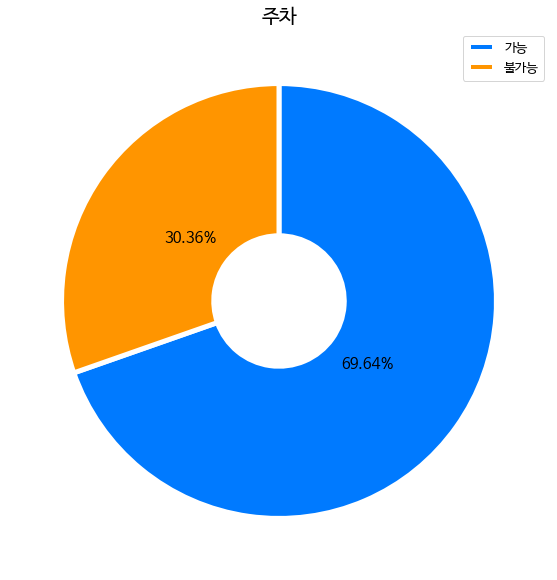

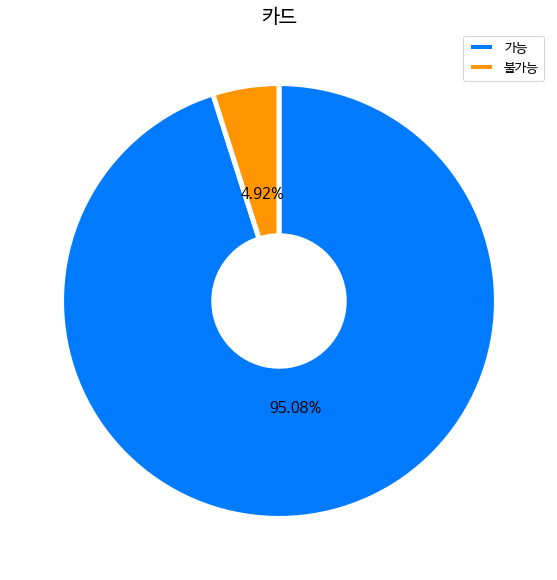

In [627]:
# 예약,배달,주차,카드,좌석수
plt.figure(figsize=(30,10))
col_list = ['예약','배달','주차','카드']

for i in range(len(col_list)):
  pie_plot(data[col_list[i]].value_counts(),data[col_list[i]].value_counts().index,light_palette,f'{col_list[i]}')

- 착한가격업소의 대부분은 예약과 카드가 가능했다.
- 하지만, 전체의 40%가 배달이 불가능했으며, 전체의 30%는 주차도 불가능했다.

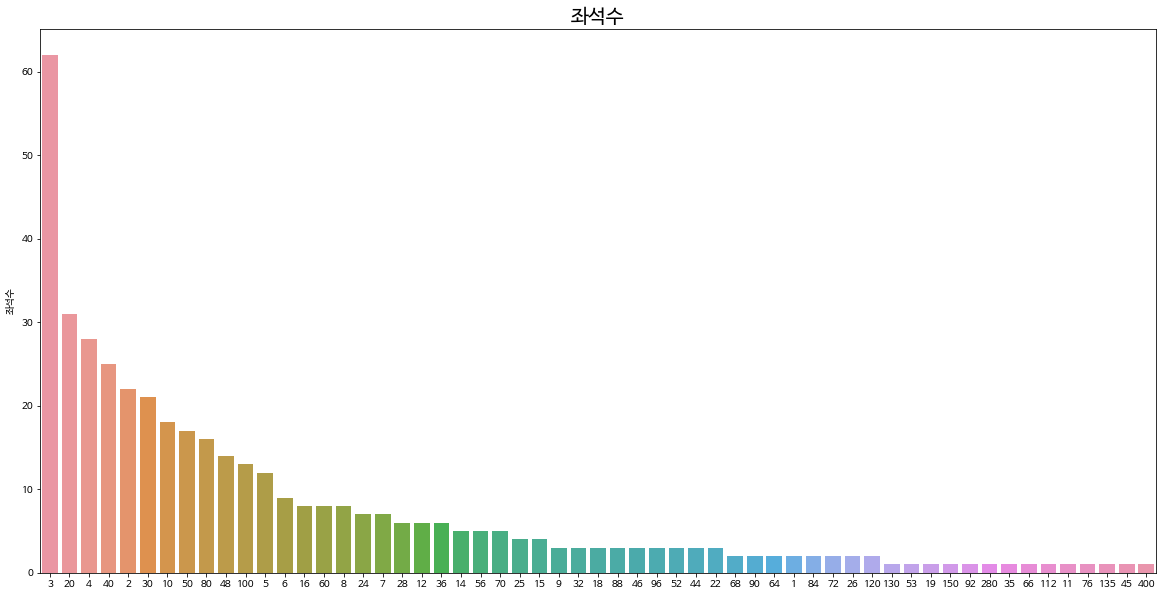

In [628]:
plt.figure(figsize=(20,10))

sns.barplot(x = data['좌석수'].value_counts().index, y = data['좌석수'].value_counts())
plt.title('좌석수',size=20)
plt.show()

- 착한가격업소의 좌석수는 3좌석이 가장 많았다.

In [652]:
def num_plot(group_col , col_list):
  plt.figure(figsize=(30,10))
  
  for i in range(len(col_list)):
    df = data.groupby(group_col).mean().sort_values(col_list[i])[::-1]

    plt.subplot(1,len(col_list),i+1)
    sns.barplot(x = df.index , y = df[col_list[i]])
    plt.title(col_list[i],size=15)

  plt.suptitle(f'{group_col}별 {col_list[i]}현황',size=20)
  plt.show()


def obj_plot(group_col,col_list):
  try:
    group_list = list(data[group_col].unique())
    group_list.remove(None)
  except:
    group_list = list(data[group_col].unique())
    
  for col in col_list:
    plt.figure(figsize=(30,10))
    plt.subplots_adjust(hspace=0.5)
    for i in range(len(group_list)):
      df = data[data[group_col] == group_list[i]]
      if df[col].isnull().sum() == len(df):
        continue

      plt.subplot(2,len(group_list)//2 + 1,i+1)
      sns.barplot(x=df[col].value_counts().index,y=df[col].value_counts())
      
      plt.xticks(rotation=90)
      plt.title(group_list[i],size=15)

    plt.suptitle(f'{group_col}별 {col}가능 현황',size=20)
    plt.show()

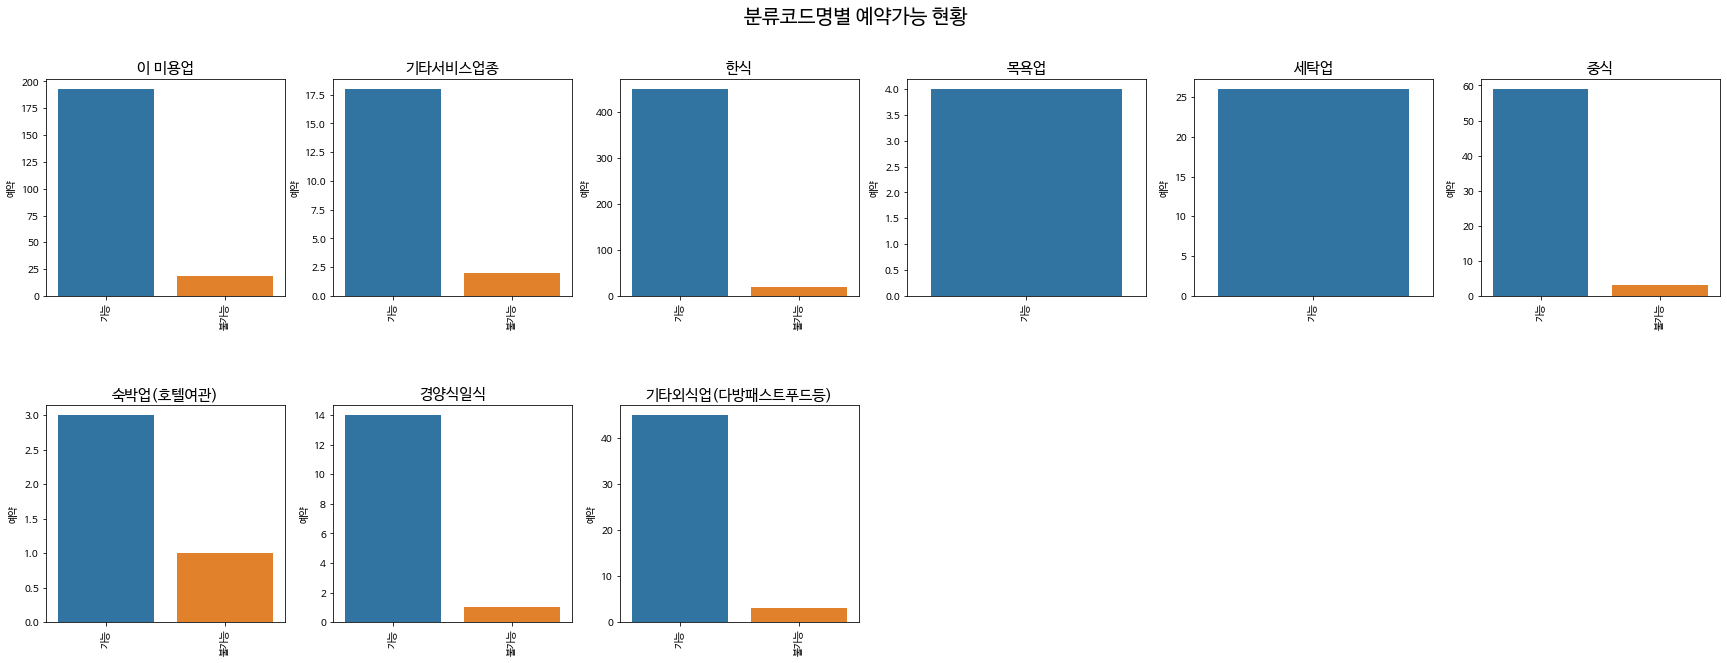

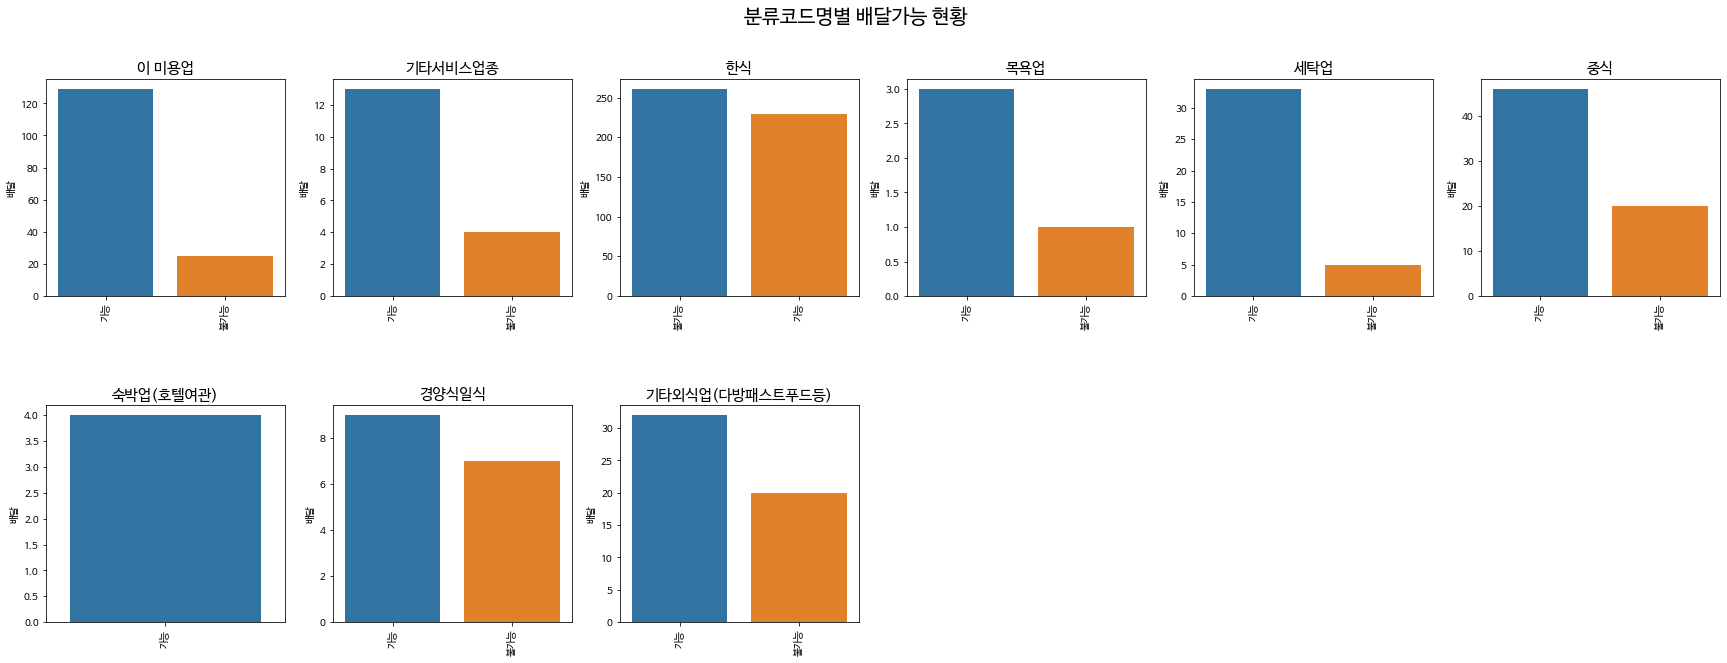

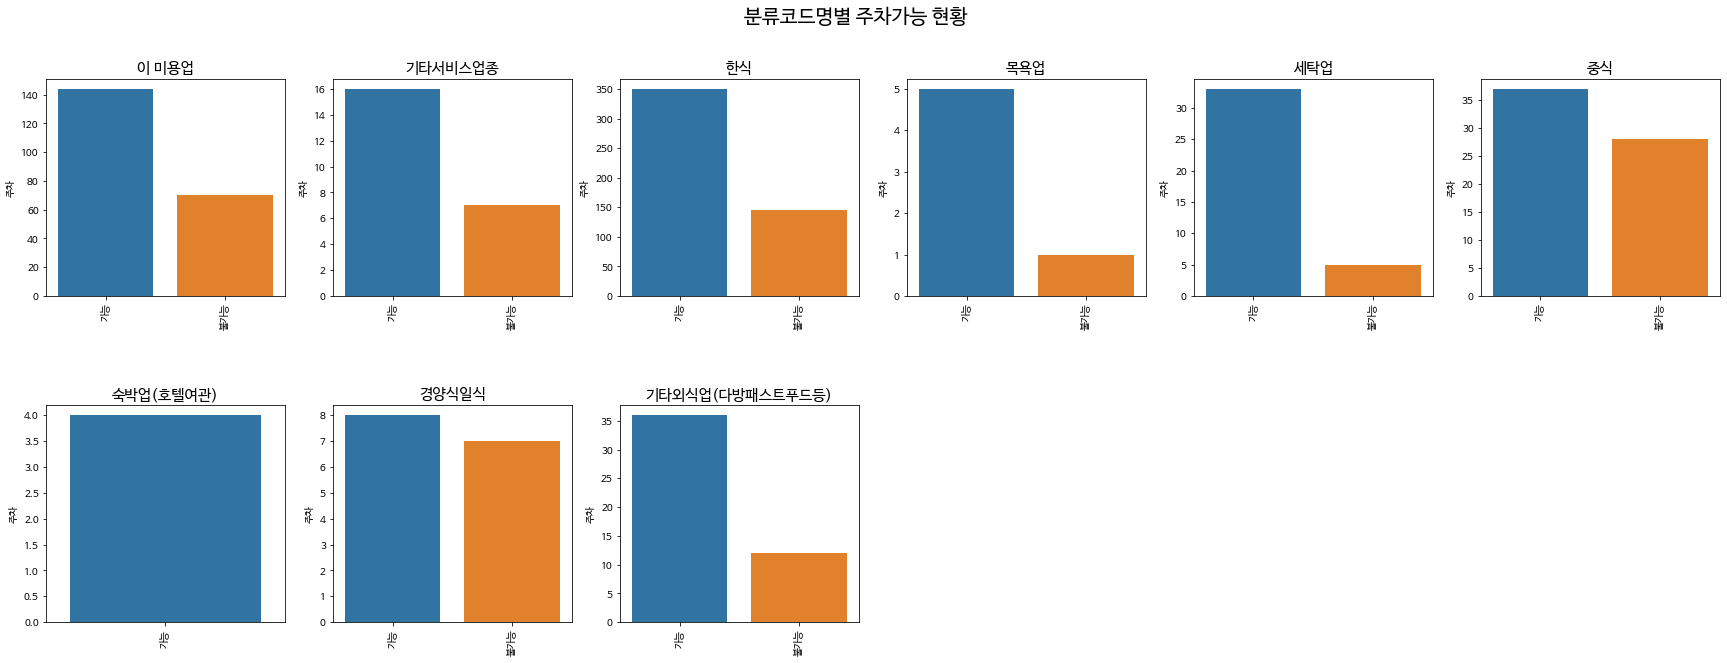

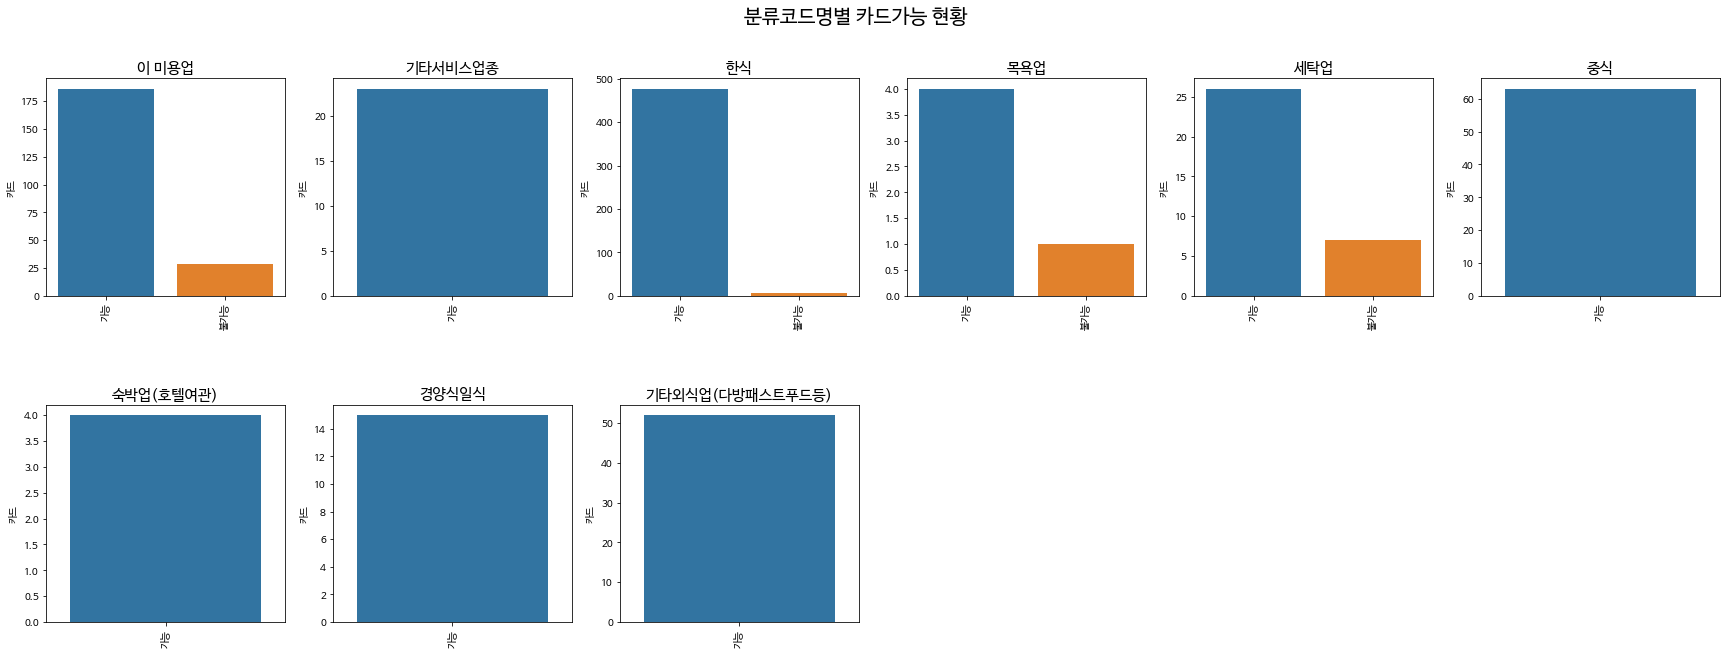

In [653]:
# 분류코드별, 위치별 영업시간,예약,배달,주차,카드,좌석수
col_list = ['예약','배달','주차','카드']
obj_plot('분류코드명',col_list)

- 목욕업과 세탁업에서는 예약이 100% 가능했다.
- 한식의 경우 배달이 불가능한 업소가 더 많았으며, 중식의 경우 대부분이 배달이 될것이라 생각했지만, 불가능한 업소가 1/3정도 나타났다.
- 주차는 경양식일식과 중식에서 불가능한 업소가 많았다.

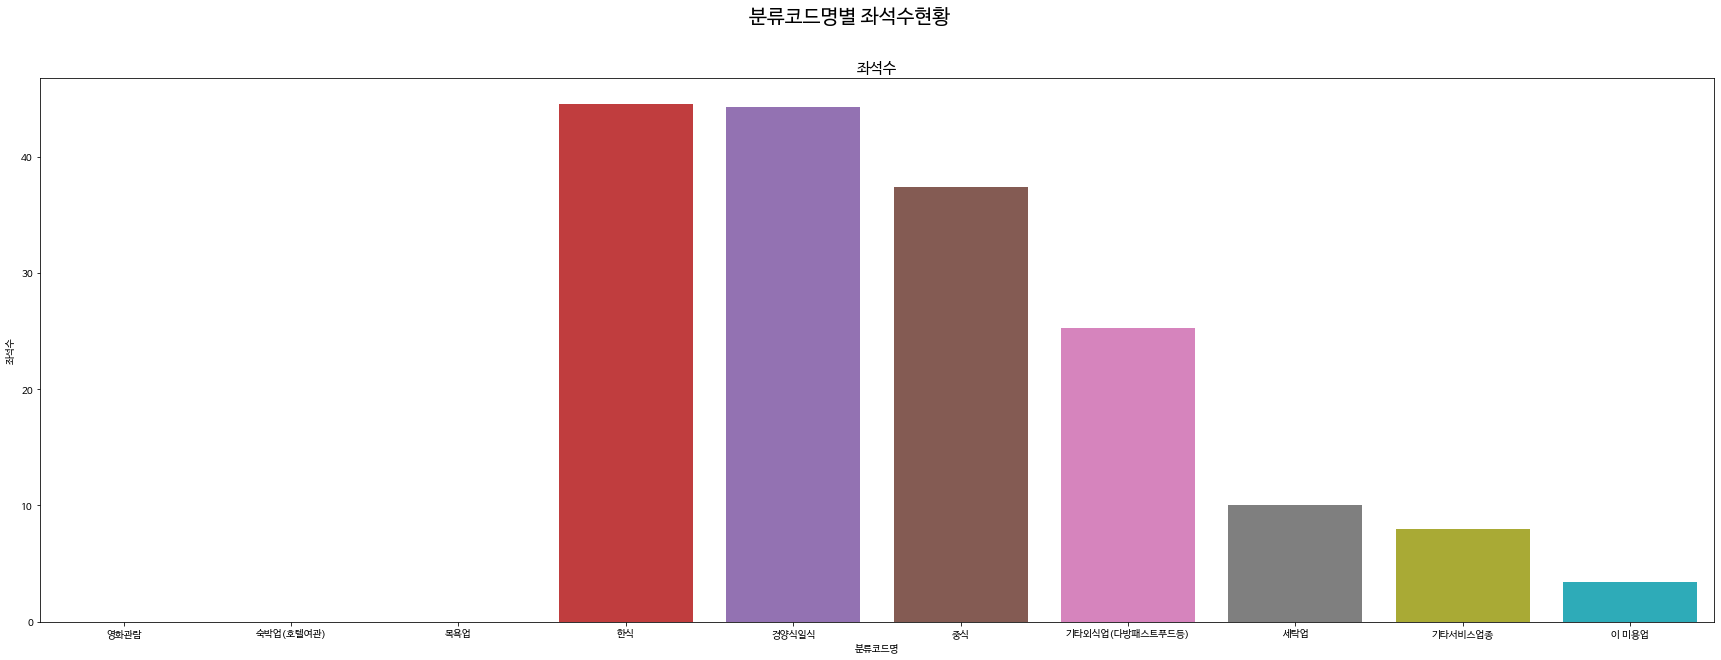

In [654]:
data['좌석수'] = data['좌석수'].map(lambda x: x if pd.isnull(x) else int(x))
num_plot('분류코드명',['좌석수'])

- 좌석수의 경우 한식과 경양식일식에서 평균 40좌석 이상이었으며, 이 미용업은 평균 약 3좌석으로 나타났다

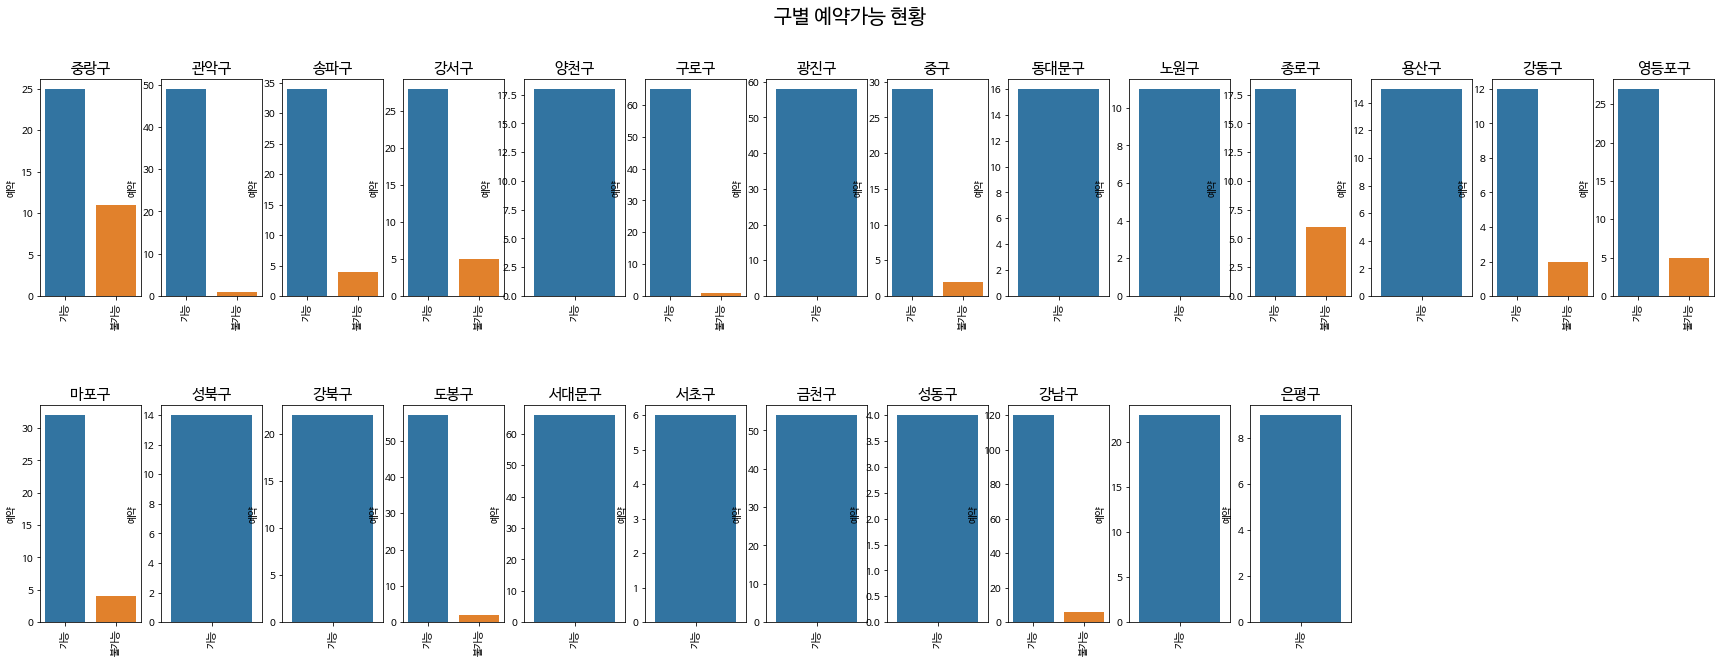

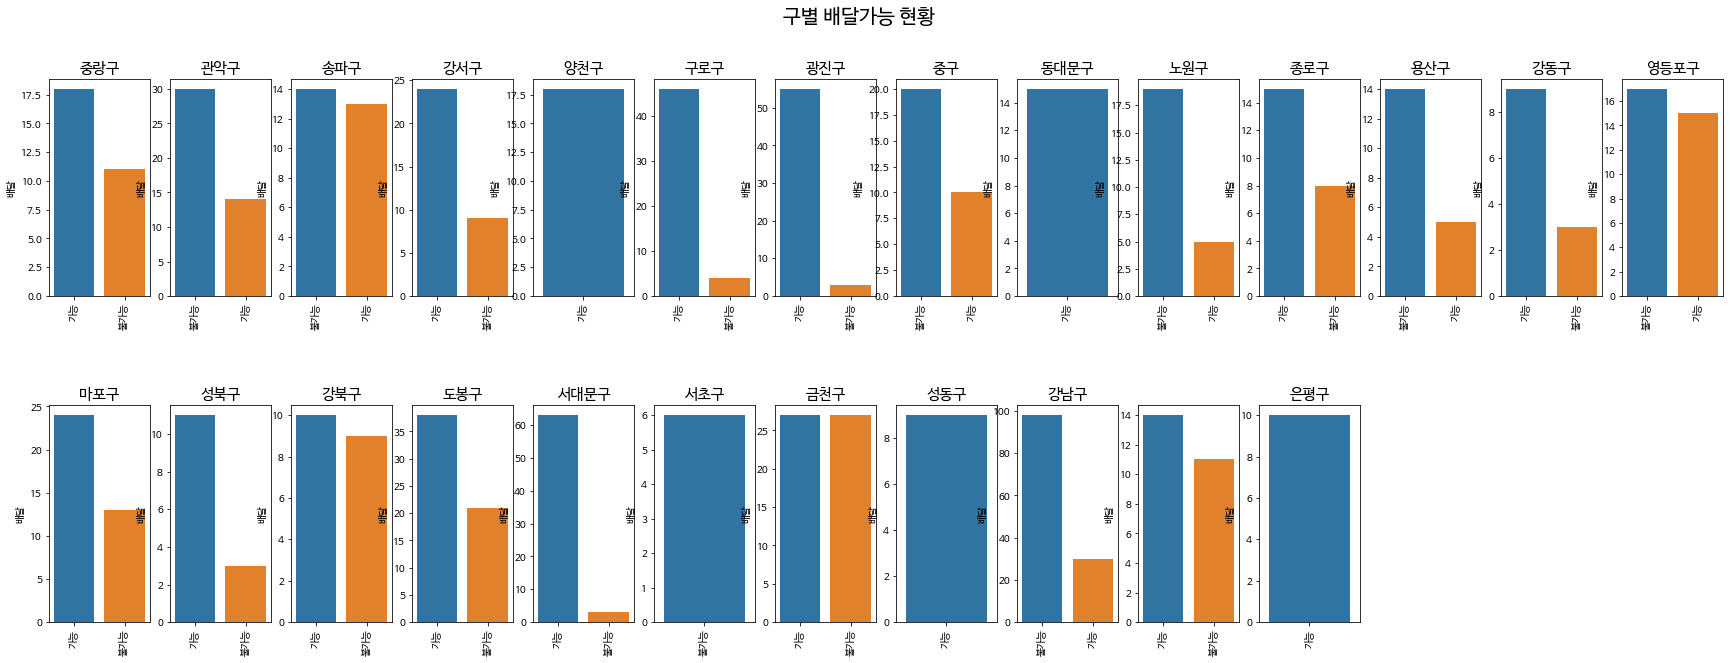

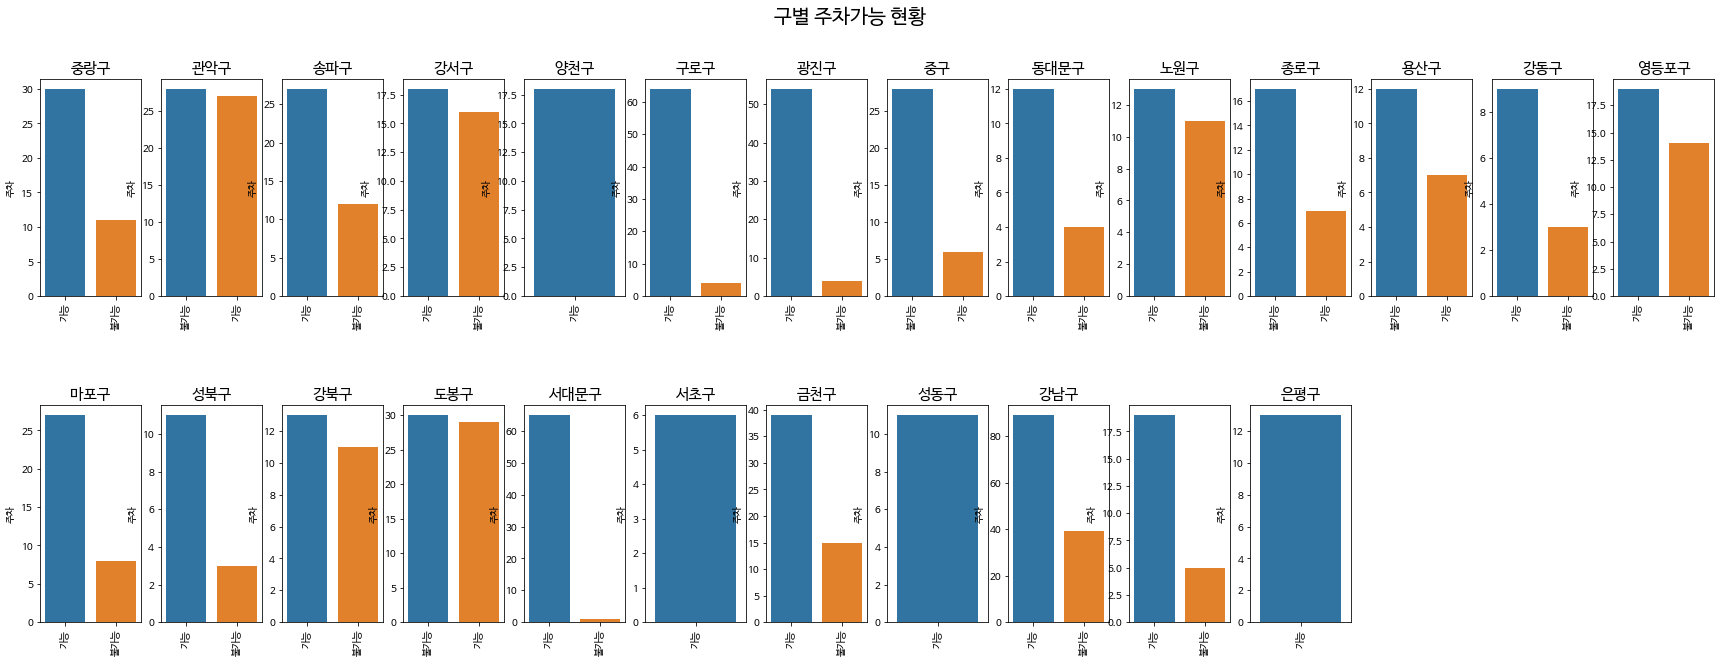

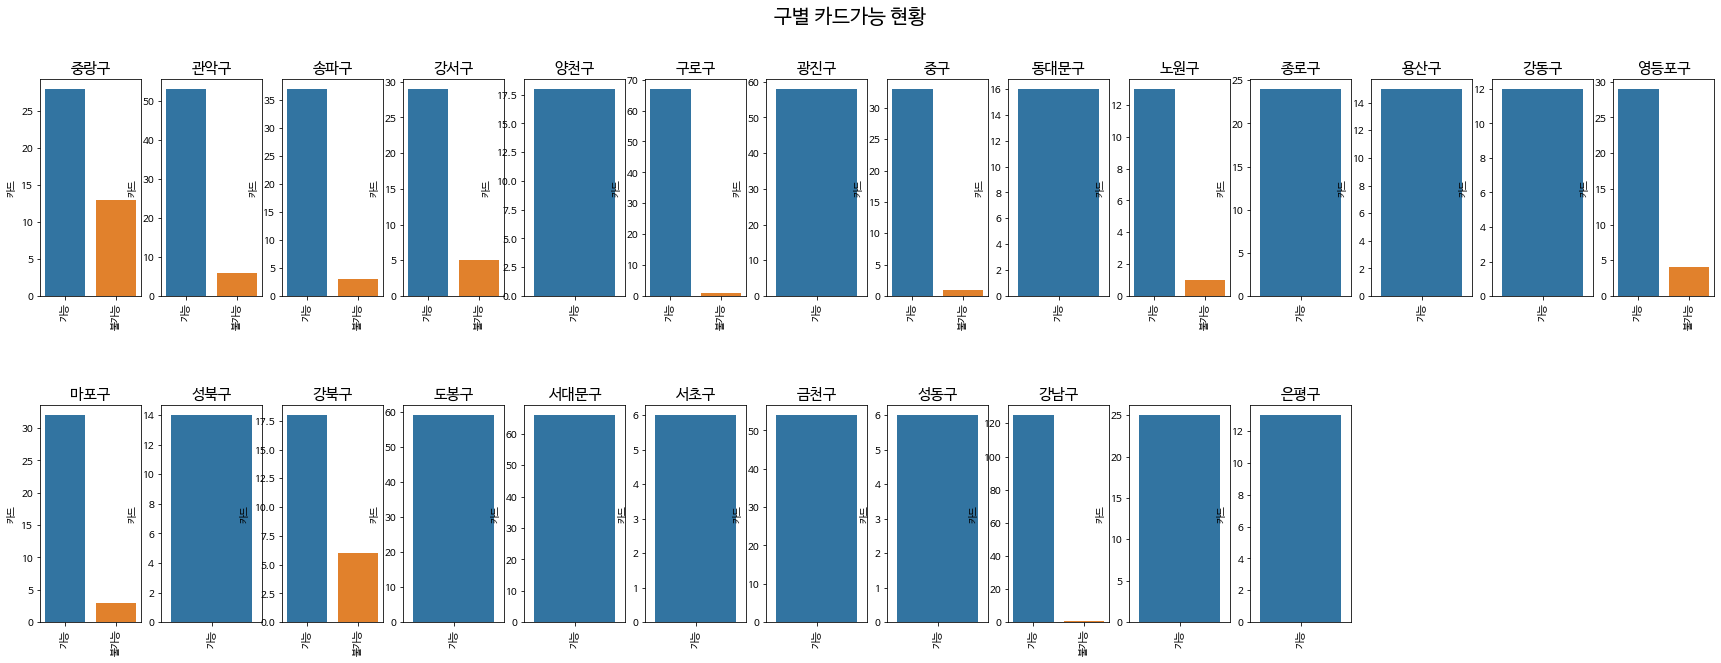

In [655]:
obj_plot('구',col_list)

In [ ]:
# 구별 시각화
import folium as g

# 위경도 0 제외
geo_df = data[data['위도'] != 0]

# 평균으로 중심 좌표 설정
center_longitude, center_latitude = geo_df['경도'].mean(), geo_df['위도'].mean()

# 중심좌표를 기준으로 맵 생성
g_map = g.Map(location=[center_latitude,center_longitude],
              tiles='Stamen Terrain',
              zoom_start=12)

# 마커 생성
color_list = ['red','blue','green','purple','orange','darkred','lightred','beige','darkblue','cadetblue','darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray',
              'red','blue','green','purple','orange','darkred','lightred','beige','darkblue','cadetblue','darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
for i in range(len(geo_df['구'].unique())):
  gu = geo_df['구'].unique()[i]
  gu_df = geo_df[geo_df['구'] == gu]
  for name,gu, lat,lng in zip(gu_df['업소명'], gu_df['구'],gu_df['위도'] , gu_df['경도']):
    if gu == '':
      marker = g.Marker([lat,lng],
                      popup=[name,gu],
                      icon= g.Icon(color='white')).add_to(g_map)
    else:
      marker = g.Marker([lat,lng],
                      popup=[name,gu],
                      icon= g.Icon(color=color_list[i])).add_to(g_map)
  print(f'{gu} : {color_list[i]}')

In [ ]:
g_map

In [ ]:
# 분류코드별 시각화
import folium as g

# 위경도 0 제외
geo_df = data[data['위도'] != 0]

# 평균으로 중심 좌표 설정
center_longitude, center_latitude = geo_df['경도'].mean(), geo_df['위도'].mean()

# 중심좌표를 기준으로 맵 생성
g_map = g.Map(location=[center_latitude,center_longitude],
              tiles='Stamen Terrain',
              zoom_start=12)

# 마커 생성
print(geo_df['분류코드명'].unique())
color_list = ['red','blue','green','purple','orange','darkred','lightred','beige','darkblue','cadetblue','darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
code_df = geo_df[geo_df['분류코드명'] == '한식']

for name,code_name, lat,lng in zip(code_df['업소명'], code_df['분류코드명'],code_df['위도'] , code_df['경도']):
  marker = g.Marker([lat,lng],
                    popup=[name,code_name],
                    icon= g.Icon(color='red')).add_to(g_map)

In [ ]:
g_map